## Modeling 
Building Models: Linear Regression and Random Forest Regressor

## 3.1) Importing Essential Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV


## 3.2) Load processed data

In [16]:
df = pd.read_csv('../data/walmart_features.csv')

# Split data into target and features
y = df['weekly_sales']
x = df.drop(columns=['weekly_sales', 'date'])

### 3.3) Train Test Split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


### Hyperparameter Tuning

In [18]:
param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

### 3.4) First model: Linear Regression

In [19]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
print("Linear Regression MAE:", mae_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
print("Linear Regression R²:", lr_r2)


Linear Regression MAE: 64606.29525460997
Linear Regression R²: 0.9399586081205946


### 3.5) Second model: Random Forest

In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("Random Forest MAE:", mae_rf)
rf_r2 = r2_score(y_test, y_pred_rf )
print("Random Forest R2:", rf_r2)

Random Forest MAE: 47568.30420229006
Random Forest R2: 0.9694492126410623


### 3.6) Third model: XGBoost

In [21]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)
 
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,              # number of random combinations to try
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(x_train, y_train)

y_pred_xg = random_search.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_xg)
r2 = r2_score(y_test, y_pred_xg)

print("Best Parameters:", random_search.best_params_)
print("Best Score (MAE):", -random_search.best_score_)

print("XGBoost MAE:", mae)
print("XGBoost R²:", r2)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=1000, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.8; tot

### Cross-validation with XGBoost

In [23]:
# Best model from tuning
best_xgb = random_search.best_estimator_

# TimeSeries CV
tscv = TimeSeriesSplit(n_splits=5)

mae_scores = -cross_val_score(
    best_xgb, x, y,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

r2_scores = cross_val_score(
    best_xgb, x, y,
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)

print("TimeSeries CV MAE scores:", mae_scores)
print("TimeSeries CV R² scores:", r2_scores)

print("\nAverage MAE:", mae_scores.mean())
print("Average R²:", r2_scores.mean())

TimeSeries CV MAE scores: [85861.35442337 70611.63445774 65494.14496309 44675.85071156
 46147.8054137 ]
TimeSeries CV R² scores: [0.95898031 0.95976523 0.95846739 0.97506876 0.97430555]

Average MAE: 62558.15799389002
Average R²: 0.9653174476522601


### 3.6) Save models

In [24]:
import joblib

joblib.dump(rf, "../models/random_forest.pkl")
joblib.dump(lr, "../models/linear_regression.pkl")
joblib.dump(best_xgb, "../models/xgb_best_model.pkl")

['../models/xgb_best_model.pkl']

### Visualizing Predictions vs Actuals (Random Forest)

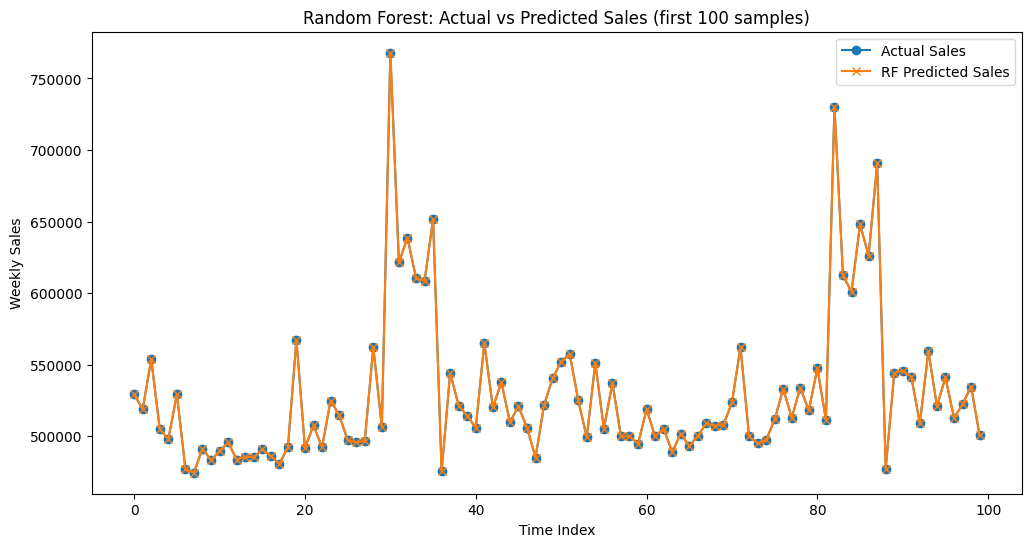

In [9]:
plt.figure(figsize=(12,6))
plt.plot(y_pred_rf[:100], label="Actual Sales", marker='o')
plt.plot(y_pred_rf [:100], label="RF Predicted Sales", marker='x')

plt.title("Random Forest: Actual vs Predicted Sales (first 100 samples)")
plt.xlabel("Time Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

### Residual Plot (Random Forest)

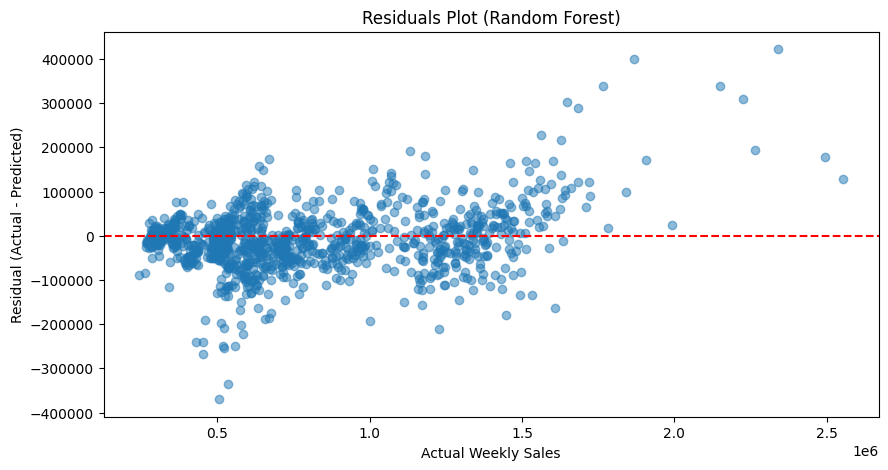

In [10]:
residuals = y_test.values - y_pred_rf

plt.figure(figsize=(10,5))
plt.scatter(y_test.values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')

plt.title("Residuals Plot (Random Forest)")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()
